In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import pandas as pd
import cartopy.mpl.ticker as cticker
from matplotlib.animation import FuncAnimation
import imageio.v2 as imageio

##convert PCT_CROP and PCT_CFT to area and do the calculations

In [3]:
file1 = '/cluster/shared/noresm/inputdata/lnd/clm2/surfdata_map/release-clm5.0.18/landuse.timeseries_1.9x2.5_SSP5-3.4_78pfts_CMIP6_simyr1850-2100_c190228.nc'     #SSP534
dset1 = xr.open_dataset(file1, decode_times=False)
dset1 = dset1.rename_dims({'lsmlat': 'Latitude', 'lsmlon': 'Longitude'})
dset1=dset1.assign_coords(Latitude=dset1['LATIXY'][:,0].values)
dset1=dset1.assign_coords(Longitude=dset1['LONGXY'][0,:].values)
#dset1['PCT_CFT_area'] =(dset1['PCT_CFT']/100)*dset1['AREA']*dset1['LANDFRAC_PFT']*(dset1['PCT_CROP']/100)
dset1['PCT_CFT_2080'] =dset1['PCT_CFT'].sel(time=2080).copy()
dset1['PCT_CFT_2015'] =dset1['PCT_CFT'].sel(time=2015).copy()
dset1['PCT_CFT_2015']


<xarray.DataArray 'PCT_CFT_2015' (cft: 64, Latitude: 96, Longitude: 144)>
[884736 values with dtype=float64]
Coordinates:
  * cft        (cft) int32 15 16 17 18 19 20 21 22 ... 71 72 73 74 75 76 77 78
  * Latitude   (Latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * Longitude  (Longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:  percent crop functional type on the crop landunit (% of landu...
    units:      unitless

In [5]:
##diff in PCT_CFT and PCT_CROP are equal. 
#Find the increase in tot area in 2090 without sugarcane area, because increase in sugarcane area needs to be kept as it is. 
TotCFTArea_diff_2090 = (dset1['PCT_CFT_new'].sel(time=2090).sum('cft')) - (dset1['PCT_CFT_new'].sel(time=2015).sum('cft'))  # increased area in 2090
TotCFTArea_diff_2090wo_cane = TotCFTArea_diff_2090 - (dset1['PCT_CFT_new'].loc[dict(cft=52, time=2090)]) # Reduce sugracane area from total area
# Calculate the increased area at grid points where TotCFTArea_diff_2090 > 0
#print(TotCFTArea_diff_2090)
#print(TotCFTArea_diff_2090wo_cane)
  
increased_area = TotCFTArea_diff_2090wo_cane#.where(TotCFTArea_diff_2090wo_cane > 0, 0)
print(increased_area)
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
TotCFTArea_diff_2090.plot()
plt.title('Diff in Area-2090-2015')
plt.text(0.5, -0.1, TotCFTArea_diff_2090.sum(), fontsize=10, color='k', ha='center', va='top', transform=plt.gca().transAxes)
axs.coastlines(linewidth=1)

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
TotCFTArea_diff_2090wo_cane.plot()
plt.title('Diff in Area-2090-2015 wo sugarcane')
plt.text(0.5, -0.1, TotCFTArea_diff_2090wo_cane.sum(), fontsize=10, color='k', ha='center', va='top', transform=plt.gca().transAxes)
axs.coastlines(linewidth=1)

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
increased_area.plot()
plt.title('Diff in Area-2090-2015 wo sugarcane')
plt.text(0.5, -0.1,  increased_area.sum(), fontsize=10, color='k', ha='center', va='top', transform=plt.gca().transAxes)
axs.coastlines(linewidth=1)
# Add the increased area to the specific cft at time=2090
updated_cft_60_2090 =  increased_area # dset1['PCT_CFT_area'].loc[dict(cft=60, time=2015)] + increased_area

# Now, Assign the updated values to the specific cft at time=2090
dset1['PCT_CFT_new'].loc[dict(cft=60, time=2090)] = updated_cft_60_2090
#dset1['PCT_CFT_area'].loc[dict(cft=60, time=2090)] = filtered_data  # Attribute the increased area to a specific crop (crop)

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
updated_cft_60_2090.plot()
axs.coastlines(linewidth=1)

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT_new'].loc[dict(cft=60, time=2090)].plot()
axs.coastlines(linewidth=1)
print(dset1['PCT_CFT_new'].loc[dict(cft=60, time=2090)].sum())

KeyError: 'PCT_CFT_new'

<xarray.DataArray 'PCT_CFT_new' ()>
array(474.25102899)
Coordinates:
    cft      int32 52
    time     int32 2090


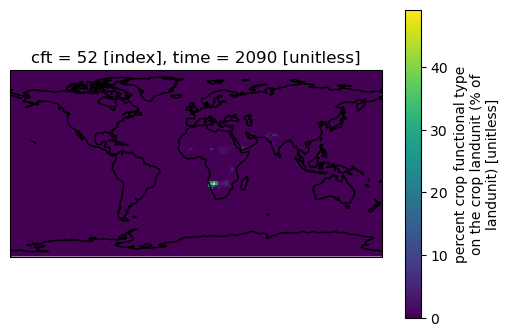

In [25]:
#Now,copy and keep the sugarcane and corn (increased) area of 2090 into a new variable 
cft_52_2090 = dset1['PCT_CFT_new'].loc[dict(cft=52, time=2090)].copy()  # Select the values for cft=52 in 2090, sugarcane
cft_60_2090 = dset1['PCT_CFT_new'].loc[dict(cft=60, time=2090)].copy()  # Select the values for cft=60 in 2090, corn
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
cft_52_2090.plot()
axs.coastlines(linewidth=1)
print(cft_52_2090.sum())

Text(0.5, -0.1, "<xarray.DataArray 'PCT_CFT_new' ()>\narray(-474.25102899)\nCoordinates:\n    cft      int32 60\n    time     int32 2090")

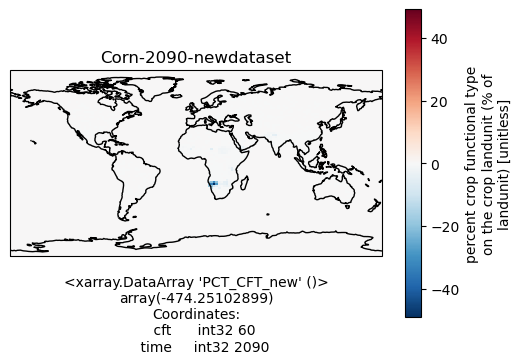

In [27]:
# creating the new dataset of 2090, first copy 2015 data to 2090, and replace the corn with the new calculated one
dset1['PCT_CFT_new'].sel(time=2090)[:] = dset1['PCT_CFT_new'].sel(time=2015)
dset1['PCT_CFT_new'].loc[dict(cft=60, time=2090)] = cft_60_2090

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT_new'].loc[dict(cft=60, time=2090)].plot()
axs.coastlines(linewidth=1)
plt.title('Corn-2090-newdataset')
plt.text(0.5, -0.1, dset1['PCT_CFT_new'].loc[dict(cft=60, time=2090)].sum(), fontsize=10, color='k', ha='center', va='top', transform=plt.gca().transAxes)




Text(0.5, -0.1, "<xarray.DataArray 'PCT_CFT_new' ()>\narray(474.25102899)\nCoordinates:\n    cft      int32 52\n    time     int32 2090")

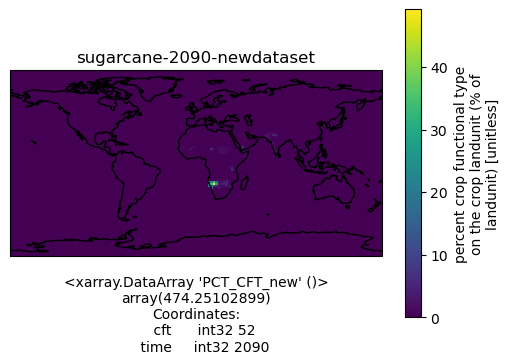

In [28]:
dset1['PCT_CFT_new'].loc[dict(cft=52, time=2090)] = cft_52_2090


fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT_new'].loc[dict(cft=52, time=2090)].plot()
axs.coastlines(linewidth=1)
plt.title('sugarcane-2090-newdataset')
plt.text(0.5, -0.1, dset1['PCT_CFT_new'].loc[dict(cft=52, time=2090)].sum(), fontsize=10, color='k', ha='center', va='top', transform=plt.gca().transAxes)




<xarray.DataArray 'PCT_CFT_new' ()>
array(1381516.37415056)
Coordinates:
    time     int32 2090


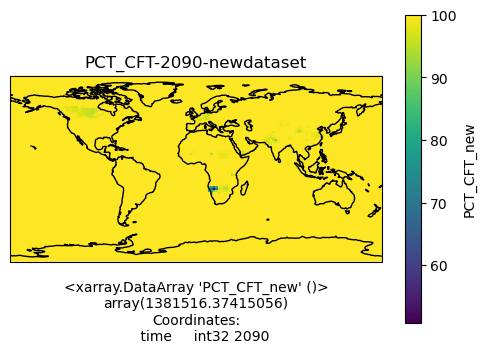

In [29]:
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT_new'].sum('cft').sel(time=2090).plot()
axs.coastlines(linewidth=1)
plt.title('PCT_CFT-2090-newdataset')
plt.text(0.5, -0.1, dset1['PCT_CFT_new'].sum('cft').sel(time=2090).sum(), fontsize=10, color='k', ha='center', va='top', transform=plt.gca().transAxes)

print(dset1['PCT_CFT_new'].sel(time=2090).sum())

In [13]:

dset1['PCT_CFT_new'].sel(time=2090)

<xarray.DataArray 'PCT_CFT' ()>
array(1382400.)
Coordinates:
    time     int32 2090


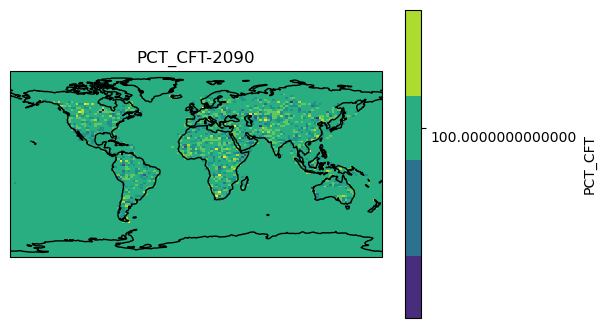

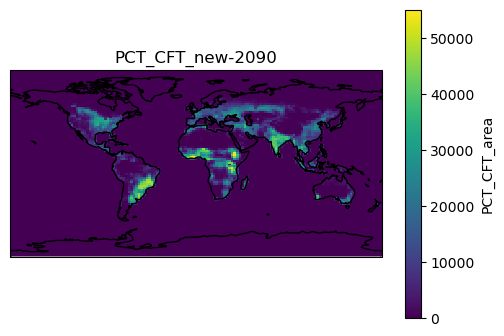

In [13]:
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT'].sum('cft').sel(time=2090).plot()
plt.title('PCT_CFT-2090')
axs.coastlines(linewidth=1)  

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT_area'].sum('cft').sel(time=2090).plot()
plt.title('PCT_CFT_new-2090')
axs.coastlines(linewidth=1) 

## Use PCT_CFT as it is and do the calculations

In [3]:
file1 = '/cluster/shared/noresm/inputdata/lnd/clm2/surfdata_map/release-clm5.0.18/landuse.timeseries_1.9x2.5_SSP5-3.4_78pfts_CMIP6_simyr1850-2100_c190228.nc'     #SSP534
dset1 = xr.open_dataset(file1, decode_times=False)
dset1 = dset1.rename_dims({'lsmlat': 'Latitude', 'lsmlon': 'Longitude'})
dset1=dset1.assign_coords(Latitude=dset1['LATIXY'][:,0].values)
dset1=dset1.assign_coords(Longitude=dset1['LONGXY'][0,:].values)



In [4]:

TotCFTArea_diff_2090 = (dset1['PCT_CFT'].sel(time=2090).sum('cft')) - (dset1['PCT_CFT'].sel(time=2015).sum('cft')) 
mask = TotCFTArea_diff_2090 > 0
masked_data = TotCFTArea_diff_2090.where(mask)          # consider only the values above zero
#dset1['temp_var'] = xr.where((TotCropArea_diff_2090 > 0) & (TotCFTArea_diff_2090 > 0), dset1['temp_var'], 0)

#dset1['PCT_CFT'].sel(time=2090)[:] = dset1['PCT_CFT'].sel(time=2015).values
print(dset1['PCT_CFT'].sel(time=2090).isel(cft=60).sum())
#dset1['PCT_CFT'].loc[dict(cft=60, time=2090)] += masked_data
dset1['PCT_CFT'] = dset1['PCT_CFT'].where(~mask, masked_data)
print(dset1['PCT_CFT'].sel(time=2090).isel(cft=60).sum())

#dset1['PCT_CFT'].to_netcdf('/cluster/projects/nn9576k/anusha/DATA/landuse.timeseries_1.9x2.5_SSP5-3.4_78pfts_CMIP6_simyr1850-2100_c1905_2090modified.nc', encoding={'PCT_CFT': {'dtype': 'float64'}})
masked_data


<xarray.DataArray 'PCT_CFT' ()>
array(15992.55632002)
Coordinates:
    cft      int32 75
    time     int32 2090
<xarray.DataArray 'PCT_CFT' ()>
array(11510.60341577)
Coordinates:
    cft      int32 75
    time     int32 2090


<xarray.DataArray 'PCT_CFT' (Latitude: 96, Longitude: 144)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * Latitude   (Latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * Longitude  (Longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5